In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#display configurations
%config InlineBackend.figure_format = 'retina'
from sklearn import set_config
set_config(display='diagram', transform_output='pandas')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import LabelEncoder

import mlflow
import mlflow.sklearn
from sklearn.model_selection import GridSearchCV

In [10]:
ml_df=pd.read_csv("/bsuhome/maishamaliha/scratch/First_chapter_ML/ml_dataset_14site.csv")

# remove null value and merging ARTRV,ARTRW to ARTR
ml_df= ml_df.dropna()
ml_df.isnull().sum()
ml_df['Species'] = ml_df['Species'].replace({'ARTRW': 'ARTR', 'ARTRV': 'ARTR'})
ml_df['Species'].unique()
val_count=ml_df['Species'].value_counts()
val_count

Species
ARTR       5746
ARAR       2503
CHVI        453
ERNA        350
Dead        233
AGCR        215
PUTR        173
ACTH        128
ELEL         94
Lupinus      93
PSSP         82
Cirsium      22
CHJU         20
Name: count, dtype: int64

#   keeping only RGB info

In [12]:
rgb_df = ml_df.loc[:, ['rgb_stdev.red','rgb_stdev.green', 'rgb_stdev.blue', 'rgb_mean.red',
 'rgb_mean.green','rgb_mean.blue', 'Species']]  
rgb_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10112 entries, 0 to 10129
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rgb_stdev.red    10112 non-null  float64
 1   rgb_stdev.green  10112 non-null  float64
 2   rgb_stdev.blue   10112 non-null  float64
 3   rgb_mean.red     10112 non-null  float64
 4   rgb_mean.green   10112 non-null  float64
 5   rgb_mean.blue    10112 non-null  float64
 6   Species          10112 non-null  object 
dtypes: float64(6), object(1)
memory usage: 632.0+ KB


In [6]:
# import import_ipynb
# from Hyper_ML import preprocess_data
# from Hyper_ML import split_data
# from ML_default import train_and_evaluate

In [13]:
def split_data(df, target_column, test_size=0.25, random_state=42):
    """Splits dataset into training and testing sets."""
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,stratify=y, random_state=random_state)
    print(f"Data Split: {len(X_train)} training samples, {len(X_test)} testing samples.")
    return X_train, X_test, y_train, y_test

In [18]:
X_train, X_test, y_train, y_test= split_data(rgb_df, 'Species',test_size=0.25, random_state=42)

Data Split: 7584 training samples, 2528 testing samples.


In [19]:
def preprocess_data(df, target_column):
    
    # identify categorical and numerical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # column transformer for preprocessing
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols)
    ])

    return df, preprocessor

In [20]:
df, preprocessor= preprocess_data(rgb_df, 'Species')

In [33]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

def train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor, model_name):
    """
    Trains and evaluates Random Forest, XGBoost, or a Stacked Ensemble Model from scratch.
    Logs results in MLflow and visualizes the confusion matrix.
    """
    # label encoding for XGBoost (required)
    label_encoder = None  
    if model_name == 'xgboost':
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(y_train)
        y_test = label_encoder.transform(y_test) 
        
    # individual models
    models = {
        'random_forest': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
        ]),
        'xgboost': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
        ]),
        'stacked_ensemble': None  # Will be created below
    }

    # base models for stacking following the pipeline from previous experiment
    base_estimators = [
        ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1)),
        ('SVM', SVC(probability=True)),
        ('GBC', GradientBoostingClassifier(random_state=42)),
        ('XGB', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
    ]

    # stacked ensemble model
    if model_name == 'stacked_ensemble':
        models['stacked_ensemble'] = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', StackingClassifier(
                estimators=base_estimators, 
                final_estimator=RandomForestClassifier(random_state=42, n_jobs=-1),  # Meta Learner
                passthrough=True, 
                n_jobs=-1
            ))
        ])

    # Select model
    if model_name not in models:
        raise ValueError(f"Model '{model_name}' not recognized. Choose from: {list(models.keys())}")

    clf = models[model_name]  

    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}", fontsize=14)
    plt.show()

    # results in MLflow
    with mlflow.start_run(run_name=f"{model_name}_evaluation"):
        mlflow.log_param("model", model_name)
        mlflow.log_metric("train_accuracy", train_acc)
        mlflow.log_metric("test_accuracy", test_acc)
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("test_f1", test_f1)

        # trained model in MLflow
        mlflow.sklearn.log_model(clf, f"{model_name}_model")

    # Print results
    print(f"\n Model: {model_name}")
    print(f" Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f" Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")


/bsuhome/maishamaliha/miniforge3/envs/climate/lib/python3.11/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


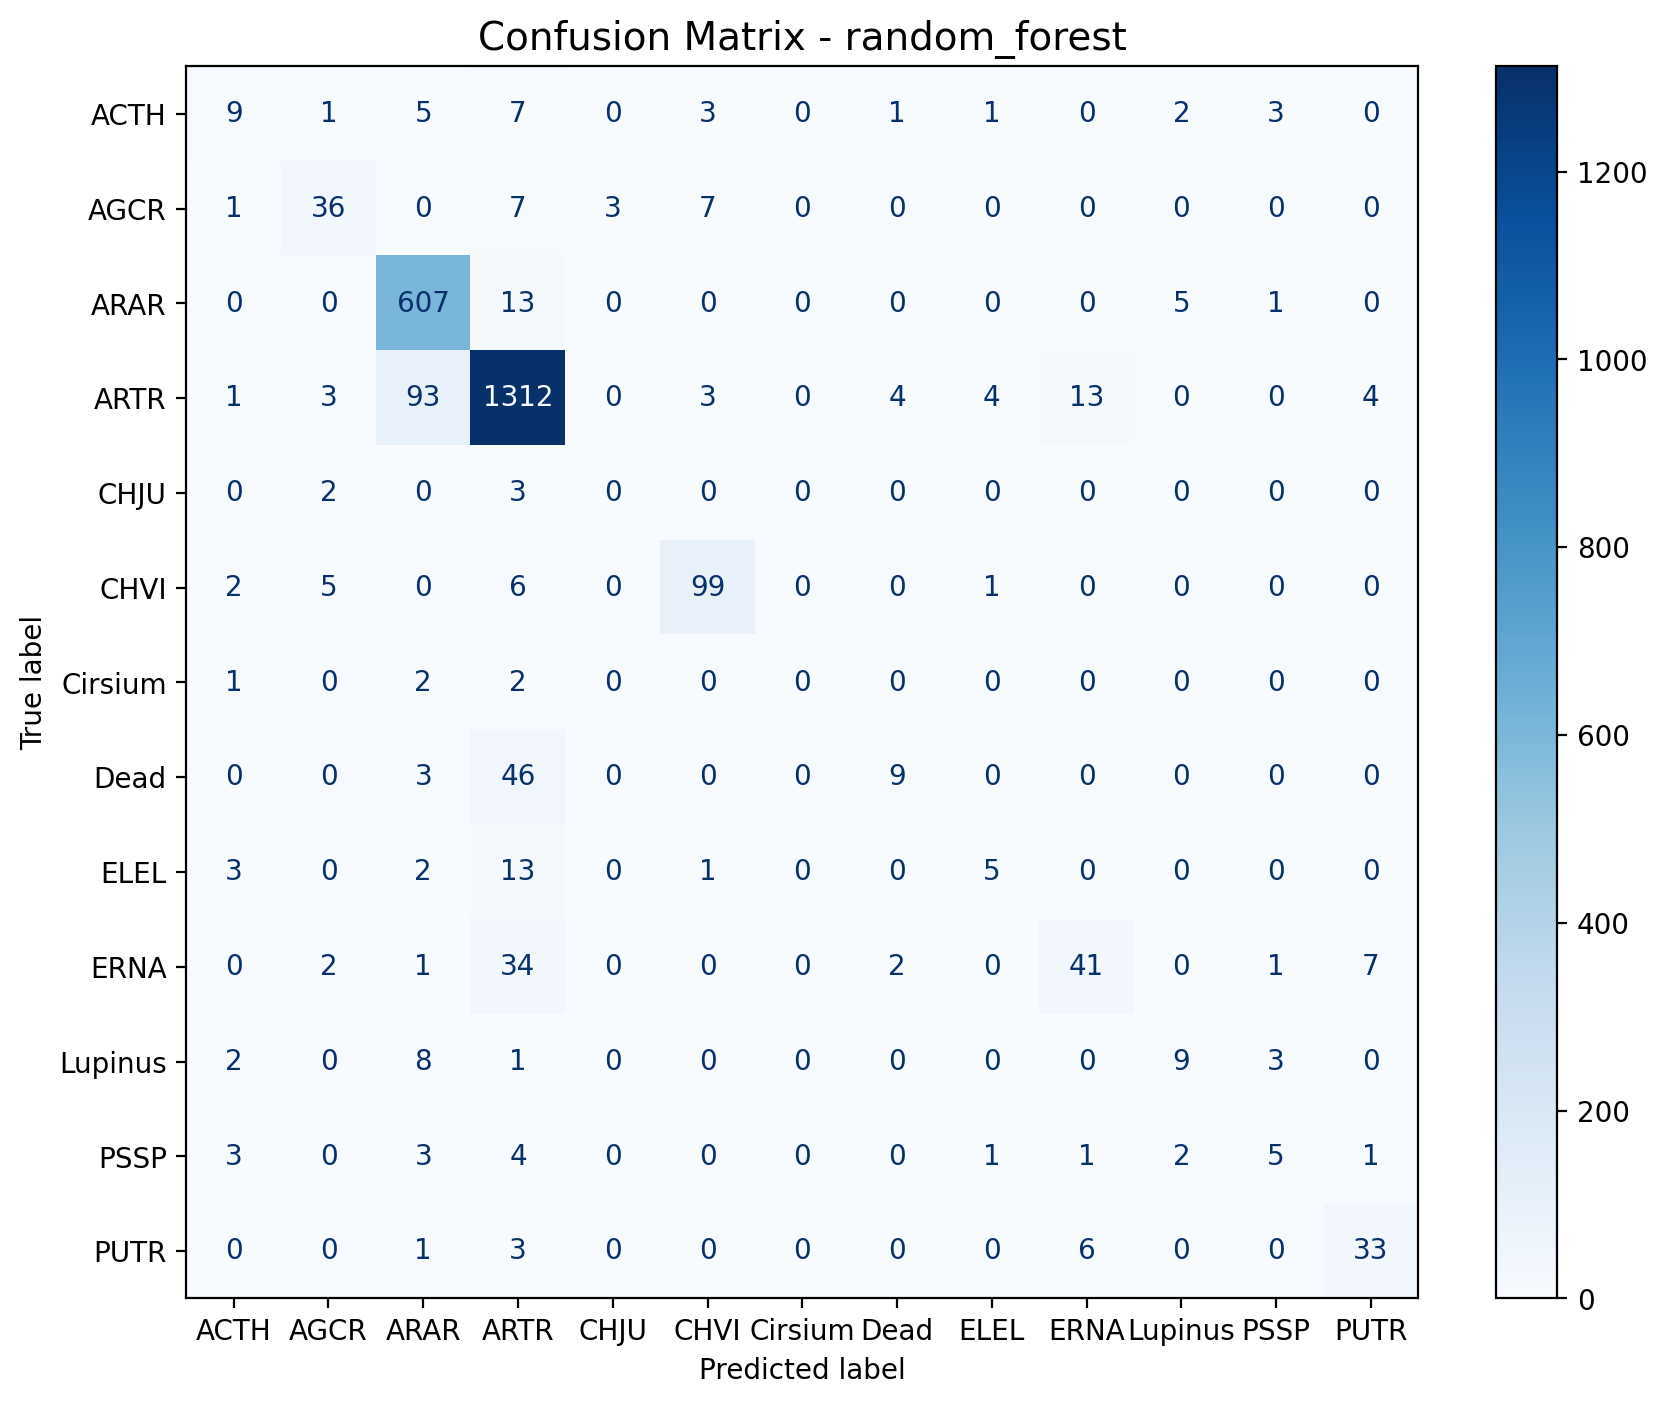


 Model: random_forest
 Train Accuracy: 1.0000, Test Accuracy: 0.8564
 Train F1 Score: 1.0000, Test F1 Score: 0.8438


In [28]:
rf_model = train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor, model_name='random_forest')

/bsuhome/maishamaliha/miniforge3/envs/climate/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:57:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[17:58:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[17:58:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[17:58:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[17:58:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[17:58:12] WARNI

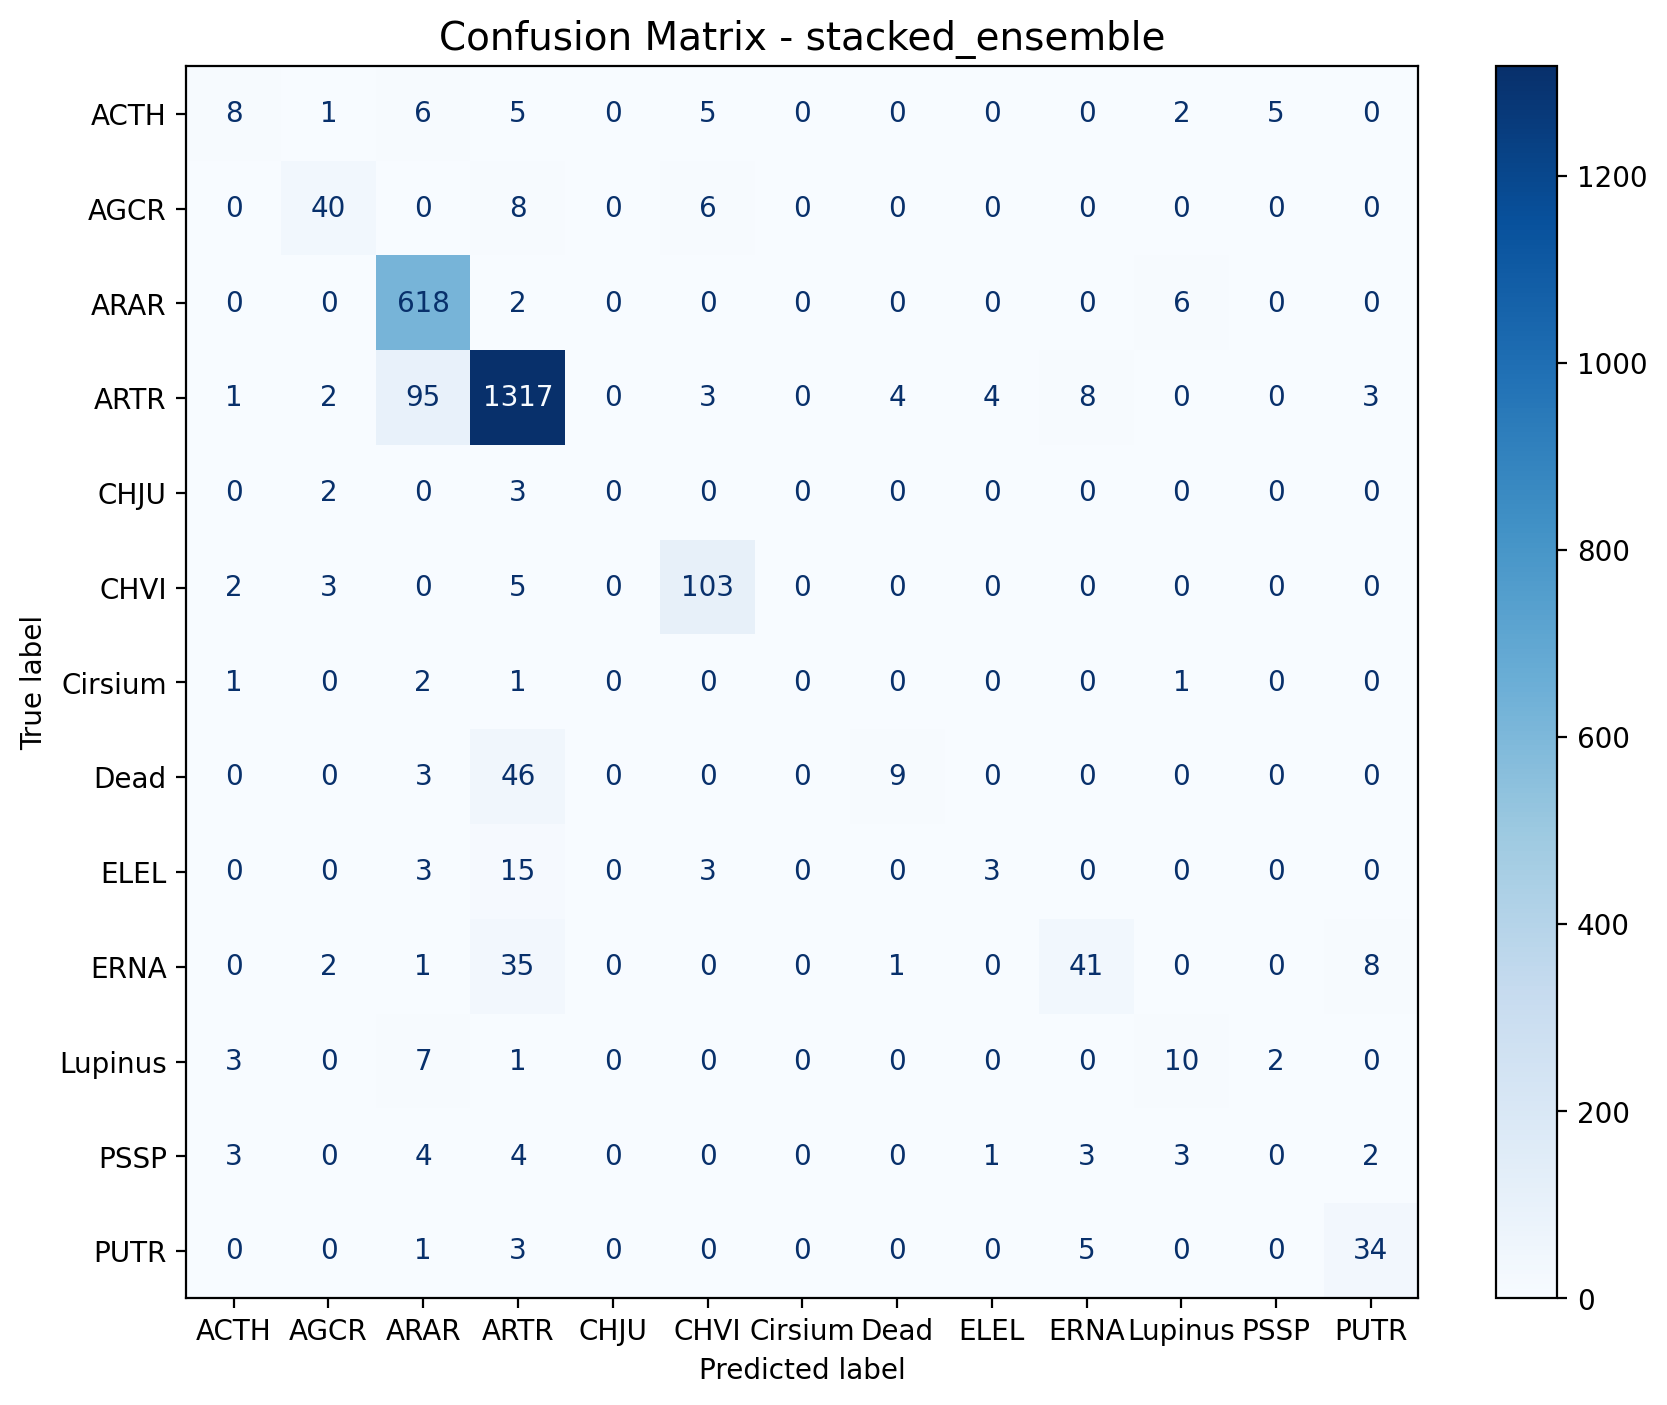


 Model: stacked_ensemble
 Train Accuracy: 0.9105, Test Accuracy: 0.8635
 Train F1 Score: 0.9040, Test F1 Score: 0.8477


In [32]:
stacked_model = train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor, model_name='stacked_ensemble')

/bsuhome/maishamaliha/miniforge3/envs/climate/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:15:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


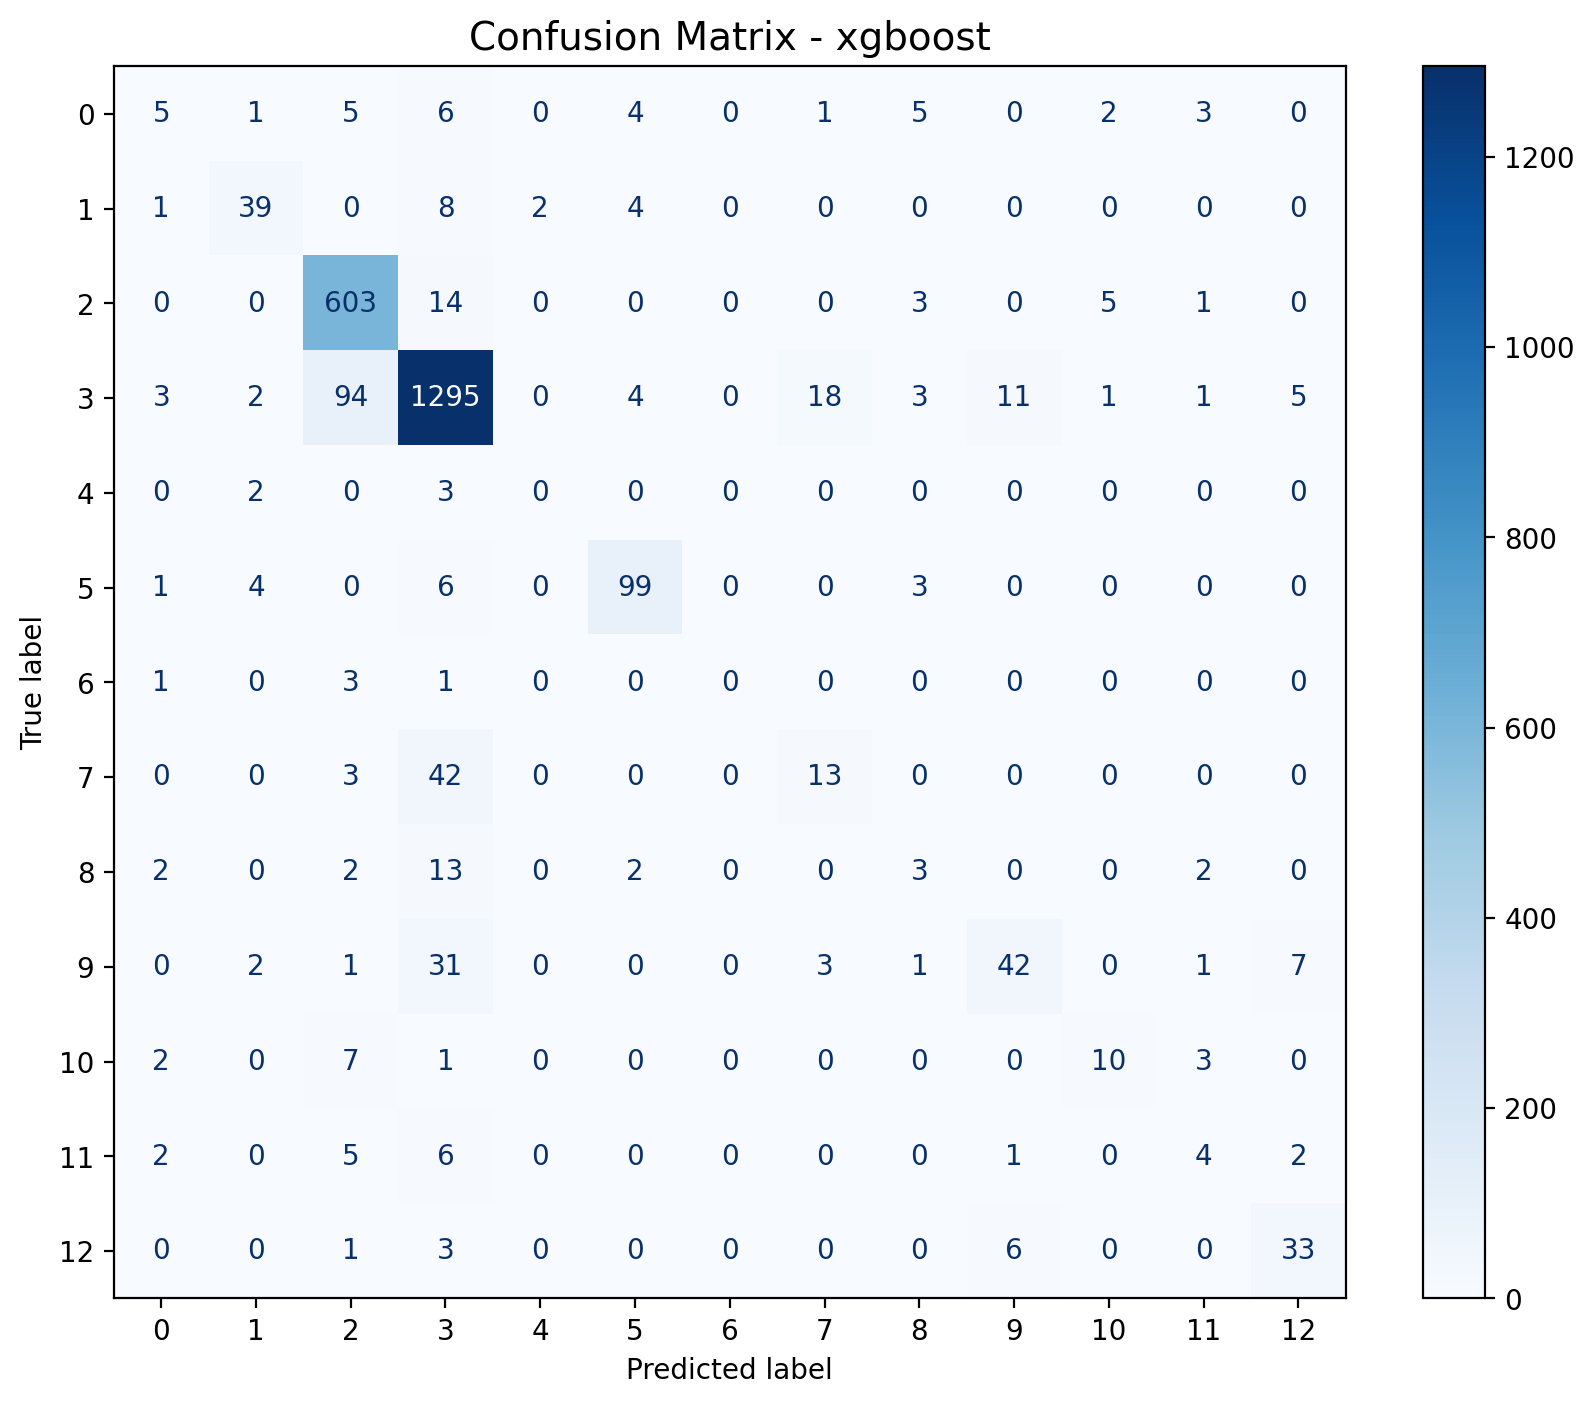


 Model: xgboost
 Train Accuracy: 0.9777, Test Accuracy: 0.8489
 Train F1 Score: 0.9778, Test F1 Score: 0.8389


In [34]:
xgb_model = train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor, model_name='xgboost')

# Keeping RGB and canopy(SfM) information removing multispectral information

In [36]:
rgb_chm= ml_df.loc[:, ['area','perimeter','edge_to_area_ratio','rgb_stdev.red','rgb_stdev.green', 'rgb_stdev.blue', 'rgb_mean.red',
 'rgb_mean.green','rgb_mean.blue', 'Species', 'chm_mean','chm_stdev','chm_min','chm_max',]] 

In [37]:
rgb_chm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10112 entries, 0 to 10129
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   area                10112 non-null  float64
 1   perimeter           10112 non-null  float64
 2   edge_to_area_ratio  10112 non-null  float64
 3   rgb_stdev.red       10112 non-null  float64
 4   rgb_stdev.green     10112 non-null  float64
 5   rgb_stdev.blue      10112 non-null  float64
 6   rgb_mean.red        10112 non-null  float64
 7   rgb_mean.green      10112 non-null  float64
 8   rgb_mean.blue       10112 non-null  float64
 9   Species             10112 non-null  object 
 10  chm_mean            10112 non-null  float64
 11  chm_stdev           10112 non-null  float64
 12  chm_min             10112 non-null  float64
 13  chm_max             10112 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.2+ MB


In [39]:
X_train, X_test, y_train, y_test= split_data(rgb_chm, 'Species',test_size=0.25, random_state=42)

Data Split: 7584 training samples, 2528 testing samples.


In [40]:
df, preprocessor= preprocess_data(rgb_chm, 'Species')

In [42]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier

def train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor, model_name):
    """
    Trains and evaluates Random Forest, XGBoost, or a Stacked Ensemble Model from scratch.
    Logs results in MLflow and visualizes the confusion matrix.
    """
    # label encoding for XGBoost (required)
    label_encoder = None  
    if model_name == 'xgboost':
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(y_train)
        y_test = label_encoder.transform(y_test) 
        
    # individual models
    models = {
        'random_forest': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
        ]),
        'xgboost': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
        ]),
        'stacked_ensemble': None  # Will be created below
    }

    # base models for stacking following the pipeline from previous experiment
    base_estimators = [
        ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1)),
        ('SVM', SVC(probability=True)),
        ('GBC', GradientBoostingClassifier(random_state=42)),
        ('XGB', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
    ]

    # stacked ensemble model
    if model_name == 'stacked_ensemble':
        models['stacked_ensemble'] = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', StackingClassifier(
                estimators=base_estimators, 
                final_estimator=RandomForestClassifier(random_state=42, n_jobs=-1),  # Meta Learner
                passthrough=True, 
                n_jobs=-1
            ))
        ])

    # Select model
    if model_name not in models:
        raise ValueError(f"Model '{model_name}' not recognized. Choose from: {list(models.keys())}")

    clf = models[model_name]  

    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues')
    plt.title(f" RGB_Chm_Confusion_Matrix - {model_name}", fontsize=14)
    plt.show()

    # results in MLflow
    with mlflow.start_run(run_name=f"{model_name}_evaluation"):
        mlflow.log_param("model", model_name)
        mlflow.log_metric("train_accuracy", train_acc)
        mlflow.log_metric("test_accuracy", test_acc)
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("test_f1", test_f1)

        # trained model in MLflow
        mlflow.sklearn.log_model(clf, f"{model_name}_model")

    # Print results
    print(f"\n Model: {model_name}")
    print(f" Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f" Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")


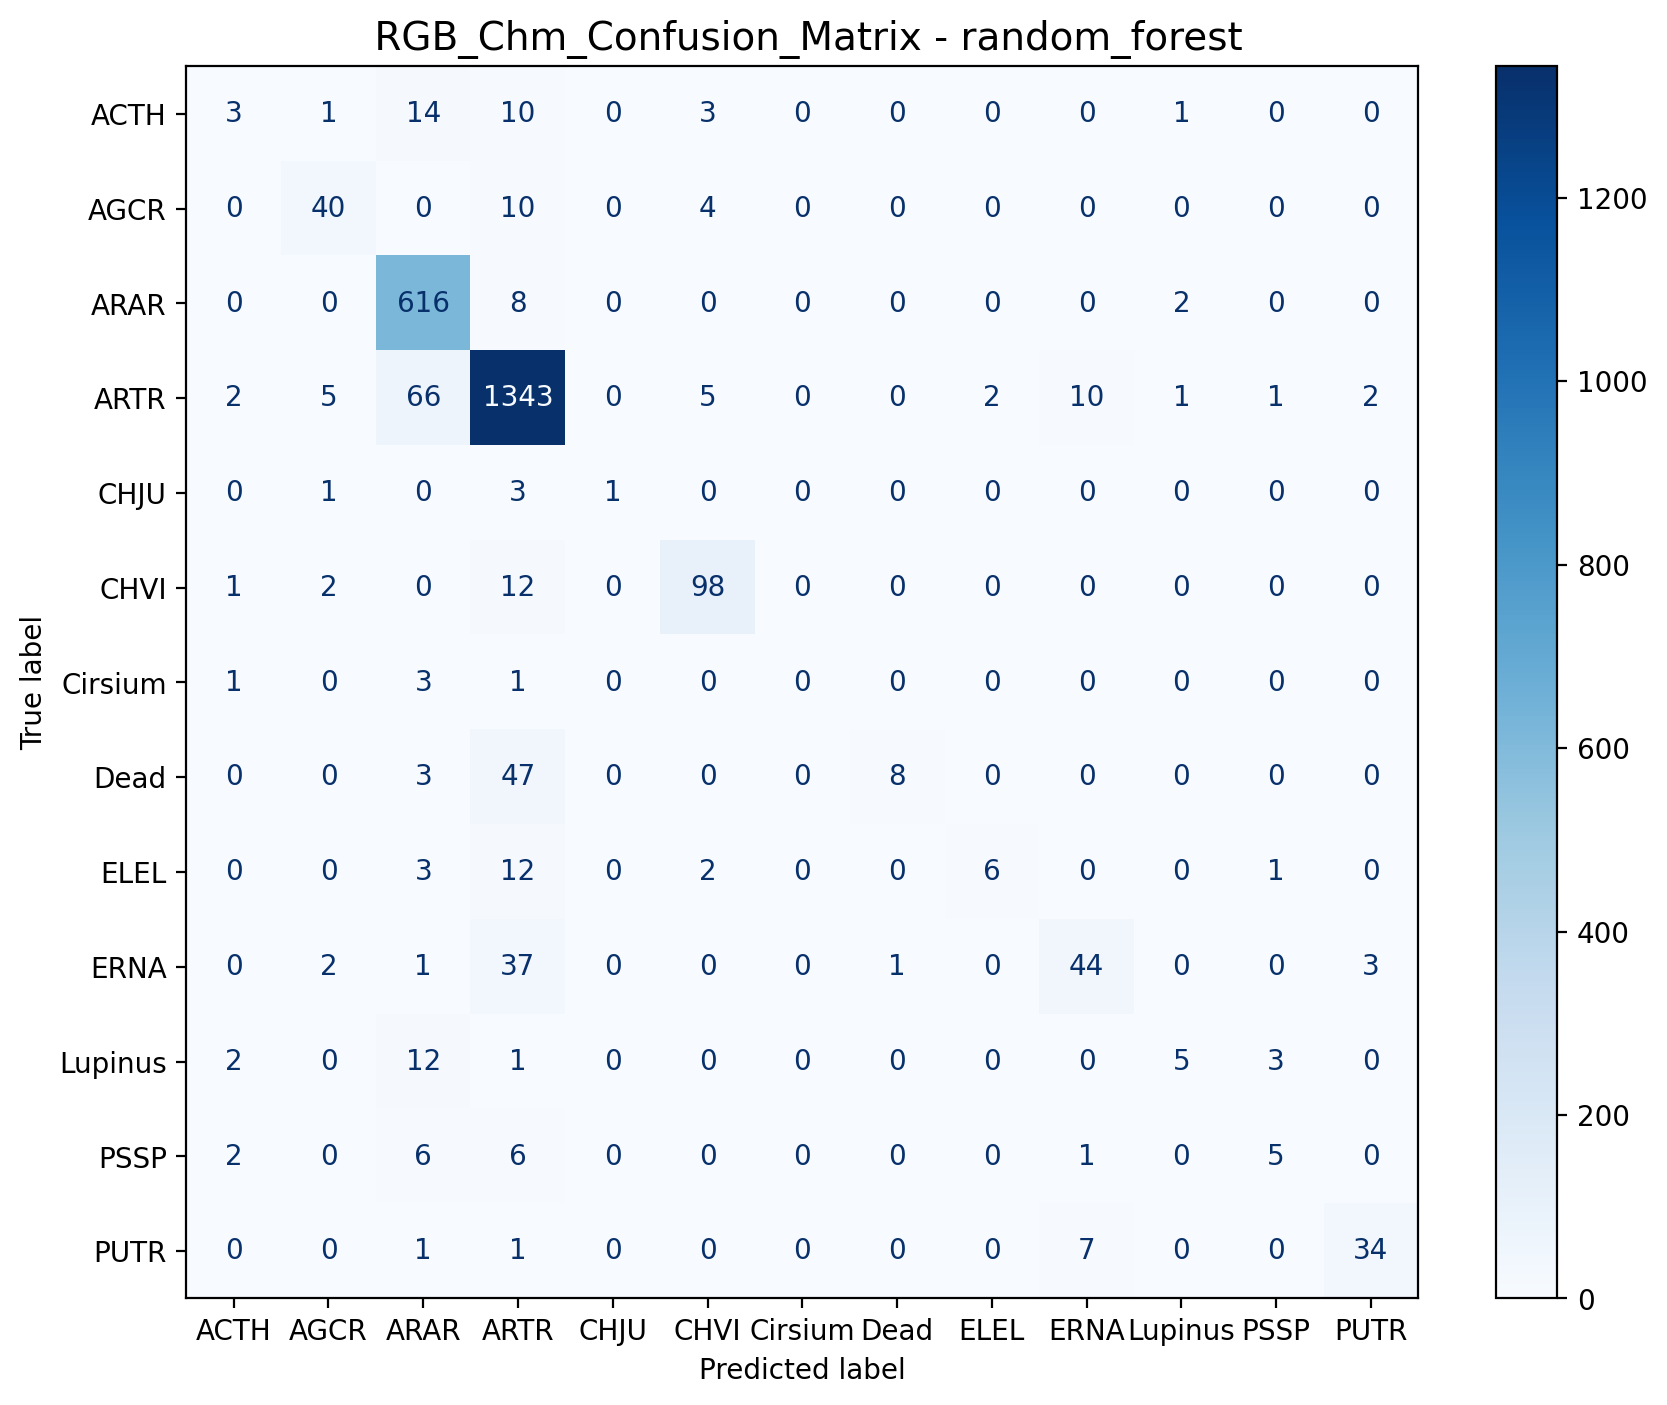


 Model: random_forest
 Train Accuracy: 1.0000, Test Accuracy: 0.8714
 Train F1 Score: 1.0000, Test F1 Score: 0.8540


In [44]:
train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor, 'random_forest')

/bsuhome/maishamaliha/miniforge3/envs/climate/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


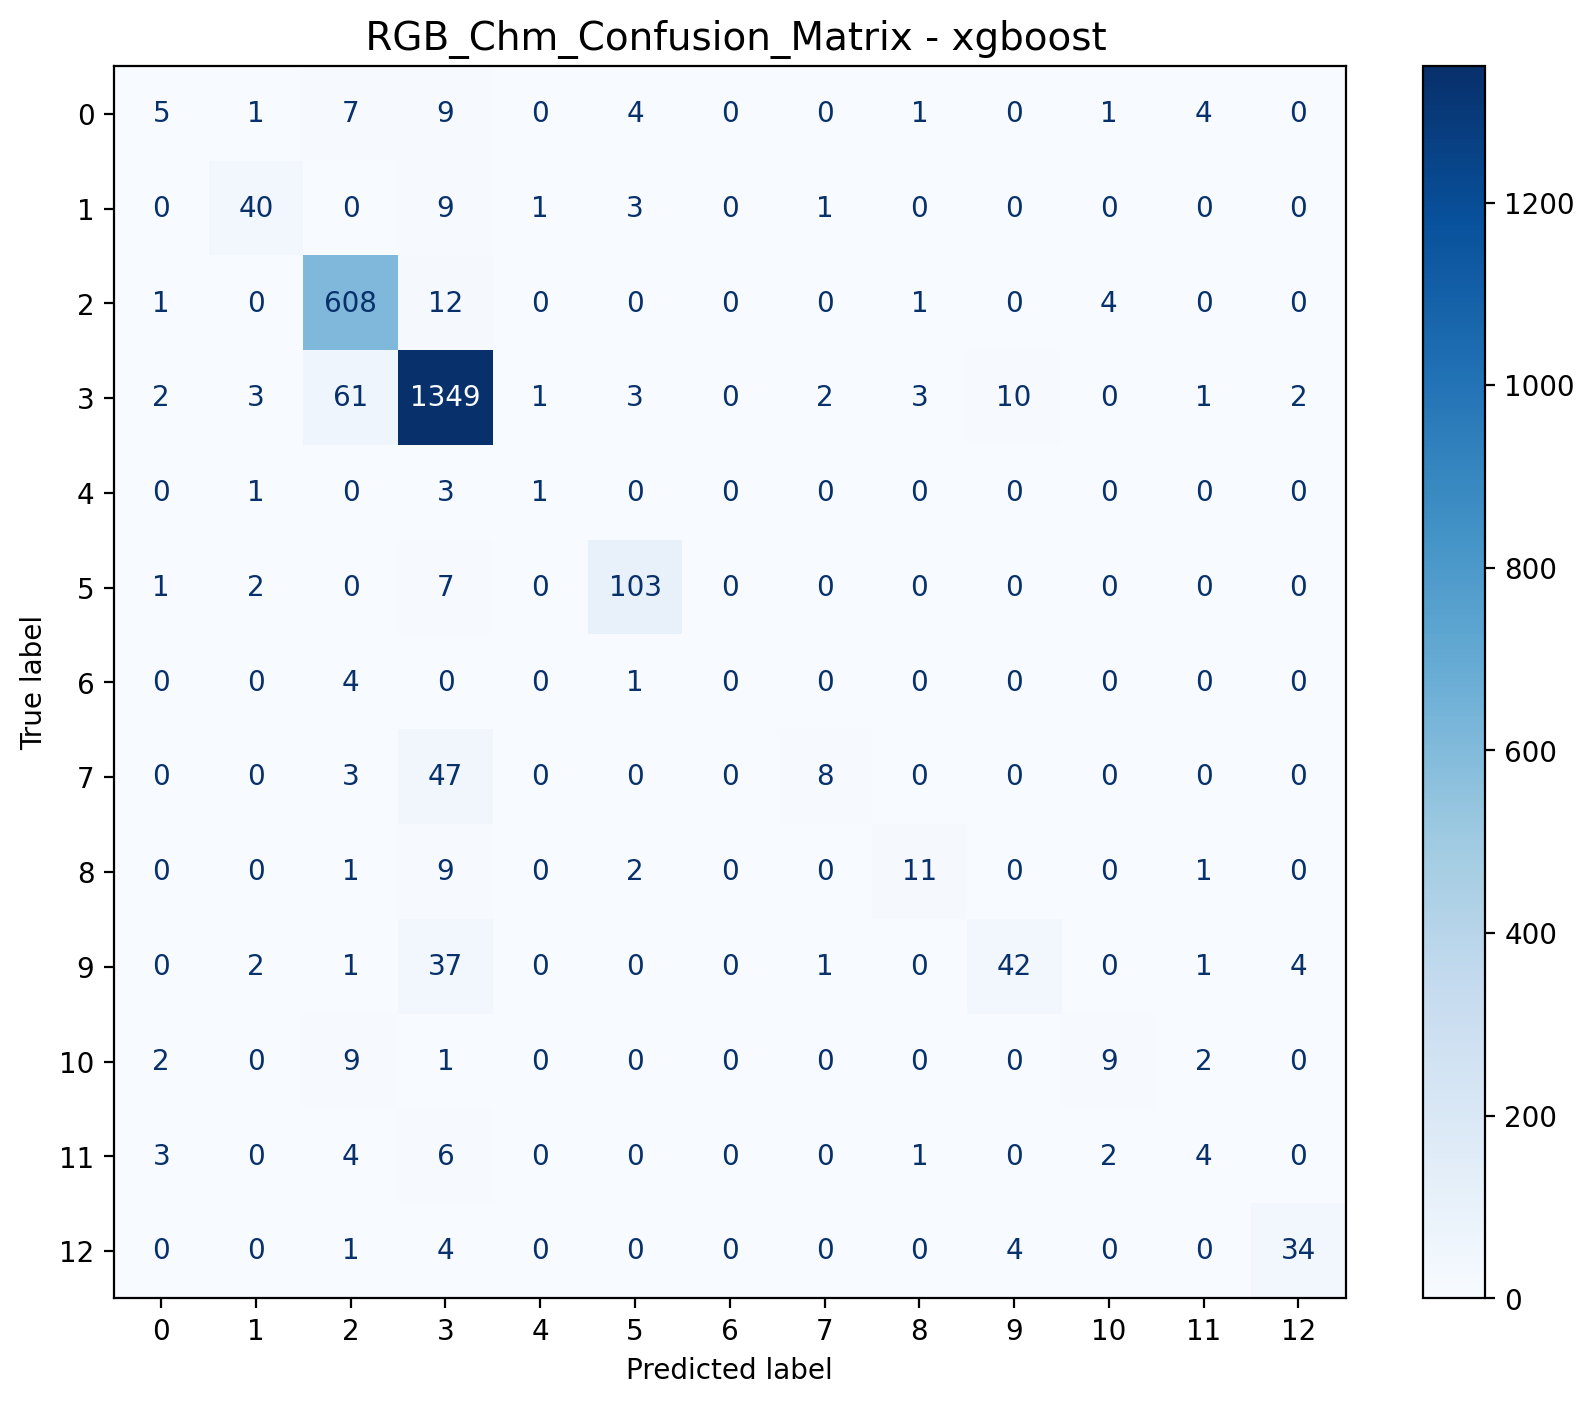


 Model: xgboost
 Train Accuracy: 0.9999, Test Accuracy: 0.8758
 Train F1 Score: 0.9999, Test F1 Score: 0.8614


In [45]:
train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor,'xgboost')

/bsuhome/maishamaliha/miniforge3/envs/climate/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[18:21:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[18:21:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[18:21:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[18:21:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[18:21:37] WARNI

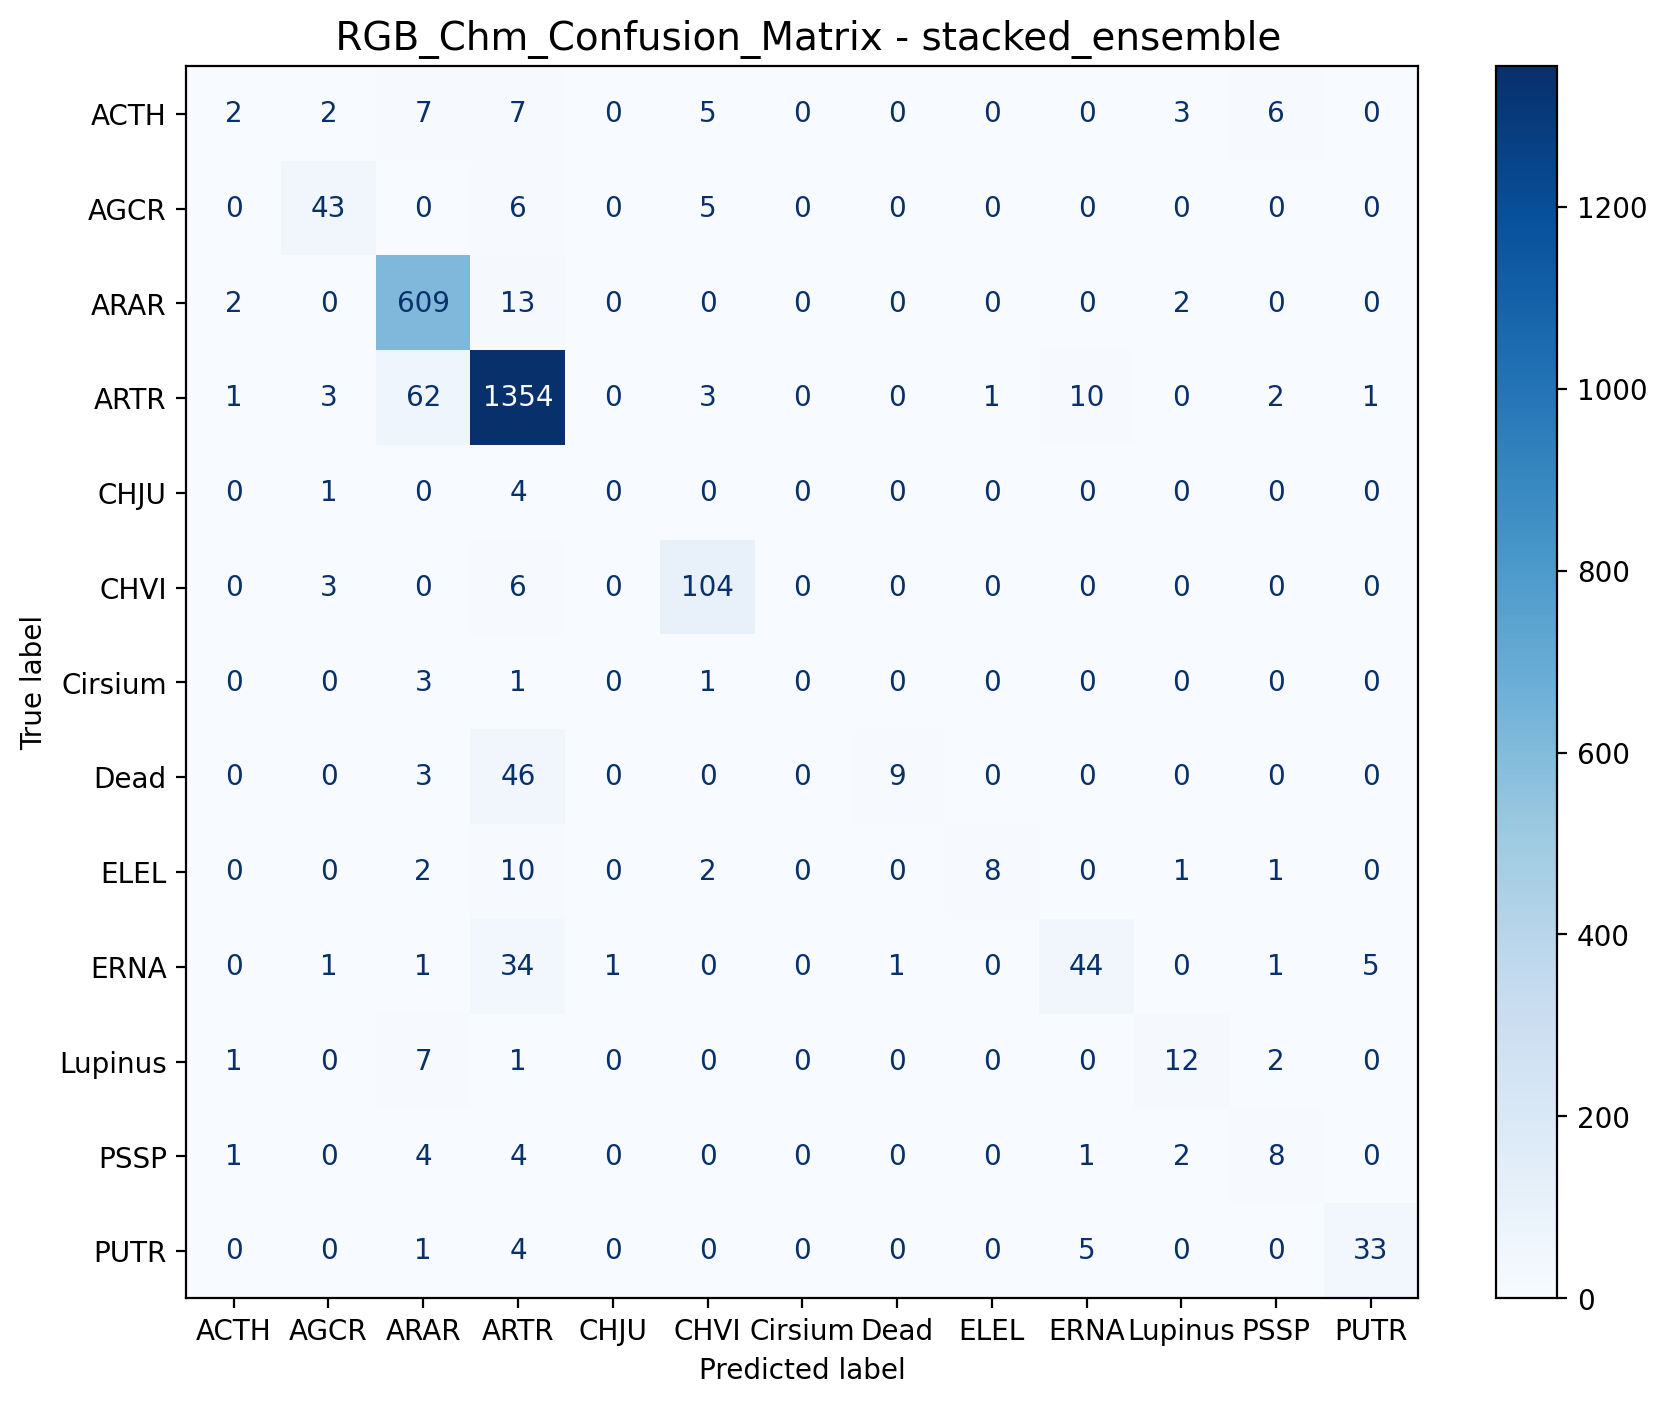


 Model: stacked_ensemble
 Train Accuracy: 0.9359, Test Accuracy: 0.8805
 Train F1 Score: 0.9282, Test F1 Score: 0.8652


In [46]:
train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor,'stacked_ensemble')

In [10]:
models =           ['Random Forest', 'xgboost', 'Stacked Ensemble']

rgb_sfm_multi_test_acc = [0.891, 0.897, 0.899]
rgb_test_acc =           [0.856, 0.848, .863]
rgb_sfm_test_acc=        [ .871, .875, .881 ]

rgb_sfm_multi_test_F1= [0.875, 0.88, 0.891]
rgb_test_F1 =          [0.844, 0.838, .847]
rgb_sfm_test_F1=       [ .854, .861 , .865]

df_result = pd.DataFrame({
    'Model': models,
    'RGB+SfM+Multi Test Acc': rgb_sfm_multi_test_acc,
    'RGB Test Acc': rgb_test_acc,
    'RGB+SfM Test Acc': rgb_sfm_test_acc,
    'RGB+SfM+Multi Test F1': rgb_sfm_multi_test_F1,
    'RGB Test F1': rgb_test_F1,
    'RGB+SfM Test F1': rgb_sfm_test_F1
})

df_result.to_csv("rgb_sfm_multi_comparison.csv", index=False)
print(df_result)

              Model  RGB+SfM+Multi Test Acc  RGB Test Acc  RGB+SfM Test Acc  \
0     Random Forest                   0.891         0.856             0.871   
1           xgboost                   0.897         0.848             0.875   
2  Stacked Ensemble                   0.899         0.863             0.881   

   RGB+SfM+Multi Test F1  RGB Test F1  RGB+SfM Test F1  
0                  0.875        0.844            0.854  
1                  0.880        0.838            0.861  
2                  0.891        0.847            0.865  


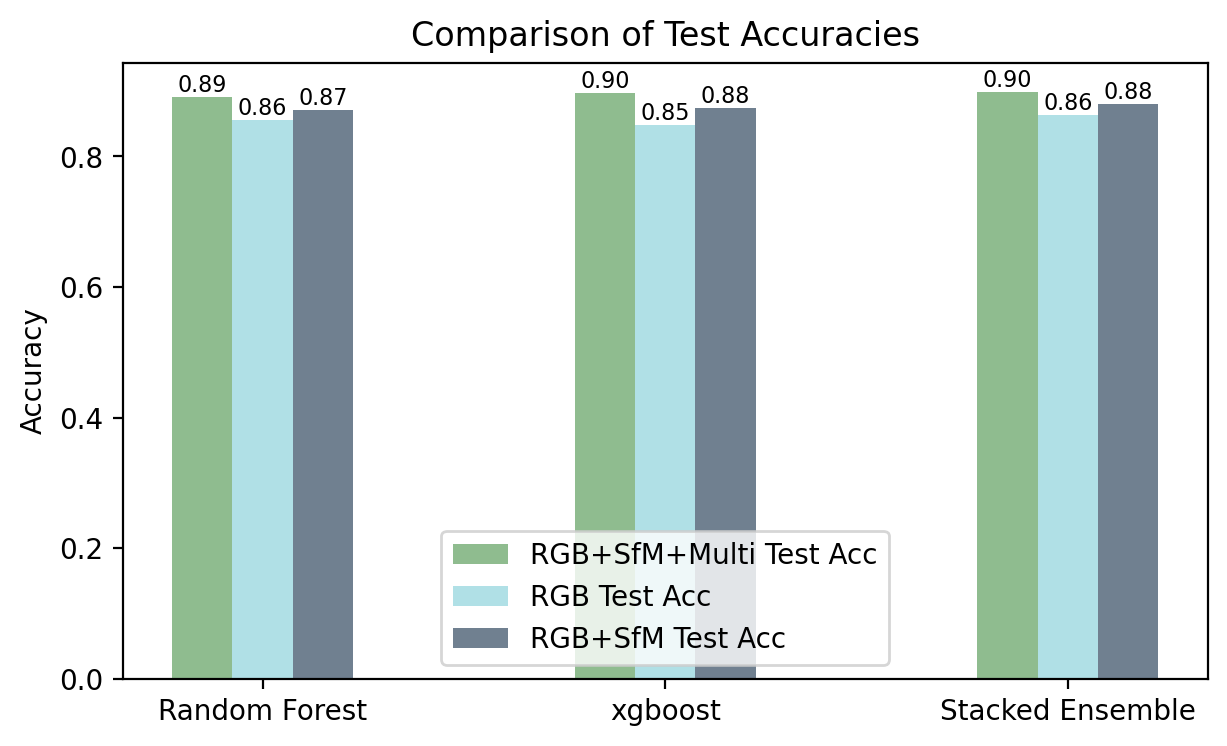

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Strip column names of leading/trailing spaces
df_result.columns = df_result.columns.str.strip()

# Extract accuracy columns
acc_columns = ['RGB+SfM+Multi Test Acc', 'RGB Test Acc', 'RGB+SfM Test Acc']

# Define models and positions for bars
models = df_result['Model']
x = np.arange(len(models))
bar_width = 0.15

# Define Colors for Accuracy Plot
acc_colors =  ['#8FBC8F', '#B0E0E6', '#708090']   # Dark Sea Green, Cadet Blue, Slate Grey

# Plot Accuracy Comparison
plt.figure(figsize=(7, 4))
for i, (col, color) in enumerate(zip(acc_columns, acc_colors)):  
    bars = plt.bar(x + i * bar_width - bar_width, df_result[col], width=bar_width, label=col, color=color)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=8)

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Comparison of Test Accuracies")
plt.legend()
plt.show()


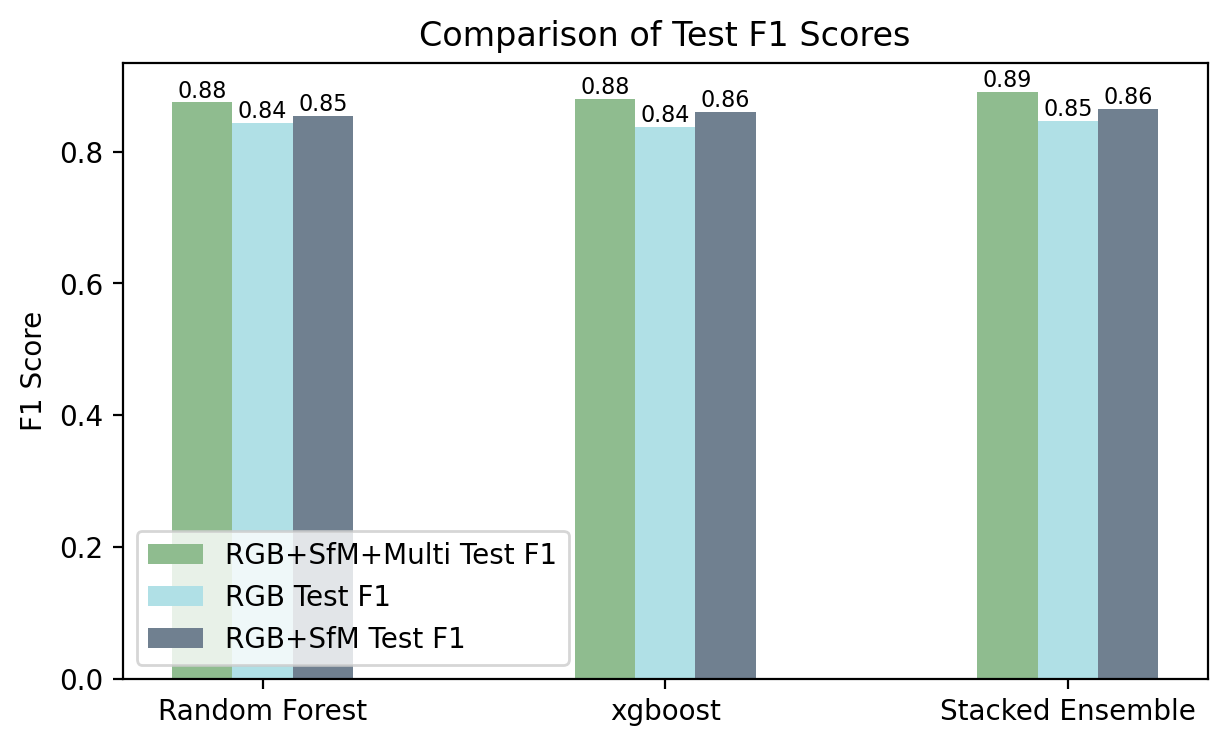

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Strip column names of leading/trailing spaces
df_result.columns = df_result.columns.str.strip()

# Extract accuracy and F1-score columns

f1_columns = ['RGB+SfM+Multi Test F1', 'RGB Test F1', 'RGB+SfM Test F1']

# Define models and positions for bars
models = df_result['Model']
x = np.arange(len(models))
bar_width = 0.15

# Define Colors
colors = ['#8FBC8F', '#B0E0E6', '#708090']  # Dark Sea Green, Cadet Blue, Slate Grey


# Plot F1 Score Comparison
plt.figure(figsize=(7, 4))
for i, (col, color) in enumerate(zip(f1_columns, colors)):  
    bars = plt.bar(x + i * bar_width - bar_width, df_result[col], width=bar_width, label=col, color=color)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=8)

plt.xticks(x, models)
plt.ylabel("F1 Score")
plt.title("Comparison of Test F1 Scores")
plt.legend()
plt.show()
